In [ ]:
!pip install keybert nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
import nltk
from keybert import KeyBERT

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Lecture 10 - Neural Networks.txt to Lecture 10 - Neural Networks.txt


CHUNKING

In [ ]:
file_path = list(uploaded.keys())[0]
with open(file_path, 'r', encoding='utf-8') as f:
    text = f.read()

# Tokenize and chunk into 600-word segments
words = nltk.word_tokenize(text)
chunk_size = 600
chunks = [' '.join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]

print(f"Total Chunks Created: {len(chunks)}")

Total Chunks Created: 35


In [ ]:
!pip install sentence-transformers tqdm

KEYWORD ACCUMULATION

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Processing Chunks: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]


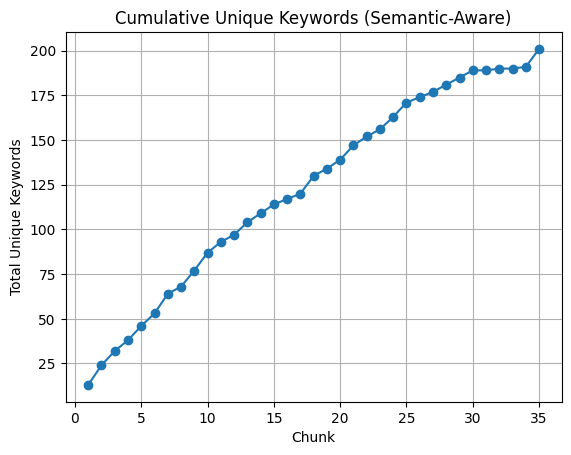

In [ ]:
kw_model = KeyBERT()
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

unique_keywords = []
unique_keyword_embeddings = []
chunk_indices = []
unique_counts = []

def is_unique(keyword, existing_embeddings, threshold=0.8):
    keyword_emb = embedding_model.encode([keyword])
    if not existing_embeddings:
        return True
    sims = cosine_similarity(keyword_emb, existing_embeddings)
    return sims.max() < threshold

for i, chunk in enumerate(tqdm(chunks, desc="Processing Chunks")):
    keywords = kw_model.extract_keywords(chunk, top_n=15, stop_words='english')
    for kw, _ in keywords:
        if is_unique(kw, unique_keyword_embeddings):
            unique_keywords.append(kw)
            unique_keyword_embeddings.append(embedding_model.encode(kw))
    chunk_indices.append(i + 1)
    unique_counts.append(len(unique_keywords))

df = pd.DataFrame({
    'Chunk': chunk_indices,
    'Cumulative_Keywords': unique_counts
})
df['New_Keywords'] = df['Cumulative_Keywords'].diff().fillna(df['Cumulative_Keywords']).astype(int)

plt.plot(df['Chunk'], df['Cumulative_Keywords'], marker='o')
plt.title("Cumulative Unique Keywords (Semantic-Aware)")
plt.xlabel("Chunk")
plt.ylabel("Total Unique Keywords")
plt.grid()
plt.show()


KDR

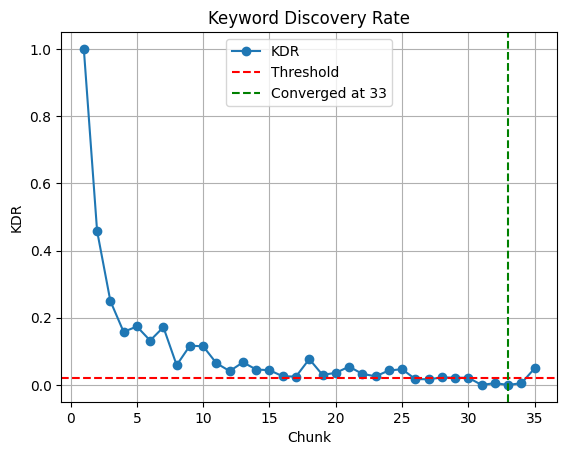

In [ ]:
df['KDR'] = df['New_Keywords'] / df['Cumulative_Keywords'].replace(0, 1)

KDR_THRESHOLD = 0.02
KDR_CONSEC = 3
kdr_converge = None
for i in range(KDR_CONSEC - 1, len(df)):
    if all(df['KDR'].iloc[i - KDR_CONSEC + 1:i + 1] < KDR_THRESHOLD):
        kdr_converge = df['Chunk'].iloc[i]
        break

plt.plot(df['Chunk'], df['KDR'], marker='o', label='KDR')
plt.axhline(KDR_THRESHOLD, color='r', linestyle='--', label='Threshold')
if kdr_converge:
    plt.axvline(kdr_converge, color='g', linestyle='--', label=f'Converged at {kdr_converge}')
plt.title("Keyword Discovery Rate")
plt.xlabel("Chunk")
plt.ylabel("KDR")
plt.grid()
plt.legend()
plt.show()


SLOPE of ACCUMULATION CURVE

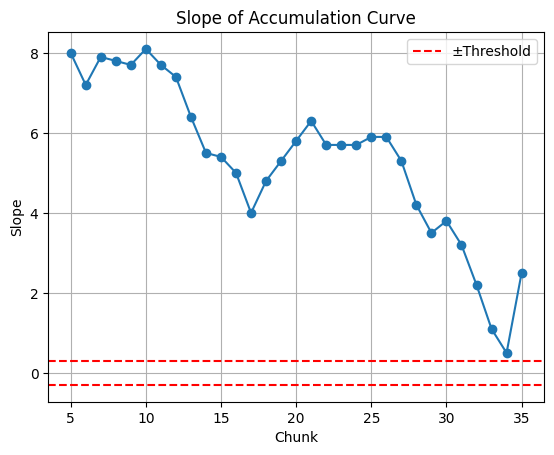

In [ ]:
from scipy.stats import linregress
import numpy as np

WINDOW = 5
slopes = [np.nan] * len(df)

for i in range(WINDOW - 1, len(df)):
    y = df['Cumulative_Keywords'].iloc[i - WINDOW + 1:i + 1]
    x = np.arange(WINDOW)
    slope, _, _, _, _ = linregress(x, y)
    slopes[i] = slope

df['Slope'] = slopes

SLOPE_THRESHOLD = 0.3
slope_converge = df[df['Slope'].abs() < SLOPE_THRESHOLD]['Chunk'].min()

plt.plot(df['Chunk'], df['Slope'], marker='o')
plt.axhline(SLOPE_THRESHOLD, color='r', linestyle='--', label='±Threshold')
plt.axhline(-SLOPE_THRESHOLD, color='r', linestyle='--')
if not np.isnan(slope_converge):
    plt.axvline(slope_converge, color='g', linestyle='--', label=f'Converged at {slope_converge}')
plt.title("Slope of Accumulation Curve")
plt.xlabel("Chunk")
plt.ylabel("Slope")
plt.grid()
plt.legend()
plt.show()


SHANNON ENTROPY

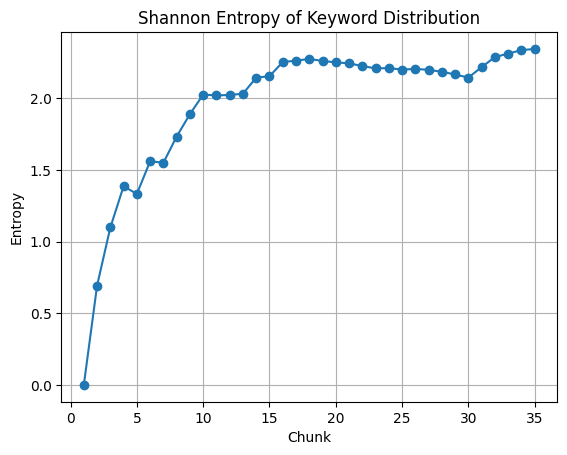

In [ ]:
from scipy.stats import entropy

keyword_bins = df['New_Keywords'].astype(int)
keyword_hist = np.zeros(int(keyword_bins.max()) + 1)
entropy_vals = []

for new_kw in keyword_bins:
    keyword_hist[int(new_kw)] += 1
    p = keyword_hist / keyword_hist.sum()
    entropy_vals.append(entropy(p))

df['Entropy'] = entropy_vals

ENTROPY_DIFF_WINDOW = 3
entropy_deltas = [np.nan] * ENTROPY_DIFF_WINDOW
for i in range(ENTROPY_DIFF_WINDOW, len(entropy_vals)):
    delta = abs(entropy_vals[i] - entropy_vals[i - ENTROPY_DIFF_WINDOW])
    entropy_deltas.append(delta)
df['Entropy_Change'] = entropy_deltas

ENTROPY_THRESHOLD = 0.05
entropy_converge = df[df['Entropy_Change'] < ENTROPY_THRESHOLD]['Chunk'].min()

plt.plot(df['Chunk'], df['Entropy'], marker='o', label='Entropy')
plt.title("Shannon Entropy of Keyword Distribution")
plt.xlabel("Chunk")
plt.ylabel("Entropy")
plt.grid()
plt.show()

EXPONENTIAL CURVE FIT

/tmp/ipython-input-14-3969447440.py:4: RuntimeWarning: overflow encountered in exp
  return a * (1 - np.exp(-b * x))


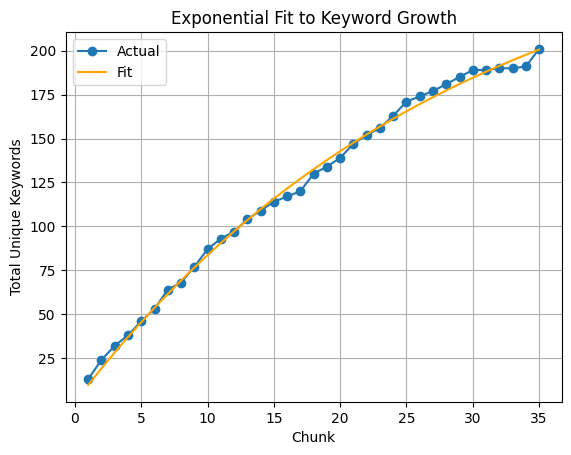

In [ ]:
from scipy.optimize import curve_fit

def growth_model(x, a, b):
    return a * (1 - np.exp(-b * x))

x = df['Chunk'].values
y = df['Cumulative_Keywords'].values

try:
    popt, _ = curve_fit(growth_model, x, y, maxfev=10000)
    a_est = popt[0]
    df['Asymptotic_Fit'] = growth_model(x, *popt)
    df['Exp_Progress'] = df['Cumulative_Keywords'] / a_est
except RuntimeError:
    a_est = np.nan
    df['Asymptotic_Fit'] = np.nan
    df['Exp_Progress'] = np.nan

EXP_THRESHOLD = 0.95
exp_converge = df[df['Exp_Progress'] >= EXP_THRESHOLD]['Chunk'].min()

plt.plot(df['Chunk'], df['Cumulative_Keywords'], marker='o', label='Actual')
plt.plot(df['Chunk'], df['Asymptotic_Fit'], color='orange', label='Fit')
if not np.isnan(exp_converge):
    plt.axvline(exp_converge, color='g', linestyle='--', label=f'95% Reached at {exp_converge}')
plt.title("Exponential Fit to Keyword Growth")
plt.xlabel("Chunk")
plt.ylabel("Total Unique Keywords")
plt.grid()
plt.legend()
plt.show()

COMBINED CRITERIA

In [ ]:
combined_converge = min(
    kdr_converge or np.inf,
    slope_converge or np.inf,
    entropy_converge or np.inf,
    exp_converge or np.inf
)

print(f"Estimated Speech Completion Point (Combined): Chunk {combined_converge}")

Estimated Speech Completion Point (Combined): Chunk 13
